In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from sklearn.utils import resample

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p, assemble_df, get_exact_p, get_fdr_p_df
from func import get_stratified_cv, cross_val_score_nuis, get_reg, corr_true_pred, root_mean_squared_error

In [4]:
parc_str = 'schaefer' # 'schaefer' 'lausanne' 'glasser'
parc_scale = 200 # 200/400 | 125/250 | 360
edge_weight = 'streamlineCount' # 'streamlineCount' 'volNormStreamline'
parcel_names, parcel_loc, drop_parcels, num_parcels = set_proj_env(parc_str = parc_str, parc_scale = parc_scale, edge_weight = edge_weight)

In [5]:
# output file prefix
outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_200_streamlineCount_'

### Setup directory variables

In [6]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline


In [7]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs


In [8]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)']
phenos_short = ['Ov. Psy.','Psy. (pos)','Psy. (neg)']

print(phenos)

metrics = ['str', 'ac']
metrics_label = ['Strength', 'Average controllability']

algs = ['rr', 'krr_rbf']
scores = ['corr', 'rmse']
seeds = np.arange(0,100)

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg']


In [9]:
num_algs = len(algs)
num_metrics = len(metrics)
num_phenos = len(phenos)
num_scores = len(scores)

## Setup plots

In [10]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Public Sans']})
cmap = my_get_cmap('pair')

In [11]:
a = 1; alg = algs[a]; print(alg)
score = scores[1]; print(score)
m = 1; metric = metrics[m]; print(metric)
p = 1; pheno = phenos[p]; print(pheno)

krr_rbf
rmse
ac
Psychosis_Positive


In [12]:
n_splits = 10

In [13]:
regs, _ = get_reg()
reg = regs[alg]
if score == 'r2':
    my_scorer = make_scorer(r2_score, greater_is_better = True)
elif score == 'corr':
    my_scorer = make_scorer(corr_true_pred, greater_is_better = True)
elif score == 'mse':
    my_scorer = make_scorer(mean_squared_error, greater_is_better = False)
elif score == 'rmse':
    my_scorer = make_scorer(root_mean_squared_error, greater_is_better = False)
elif score == 'mae':
    my_scorer = make_scorer(mean_absolute_error, greater_is_better = False)
my_scorer

make_scorer(root_mean_squared_error, greater_is_better=False)

## Load data

In [14]:
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'store', outfile_prefix+'df.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)

X = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'X.csv'))
X.set_index(['bblid', 'scanid'], inplace = True)
X = X.filter(regex = metric)

y = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'y.csv'))
y.set_index(['bblid', 'scanid'], inplace = True)
y = y.loc[:,pheno]

c = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'c.csv'))
c.set_index(['bblid', 'scanid'], inplace = True)

num_subjects = df.shape[0]; print(num_subjects)

1068


In [15]:
predictiondir = os.path.join(os.environ['PIPELINEDIR'], '3_prediction_rnr', 'out', outfile_prefix)
predictiondir

'/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/3_prediction_rnr/out/schaefer_200_streamlineCount_'

-0.9980049692074731


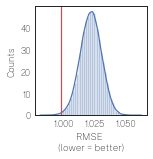

In [16]:
indir = predictiondir + 'predict_symptoms_scv_nuis'

accuracy_mean = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_mean_nuis.txt'))
print(accuracy_mean)
permuted_acc = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'permuted_acc_nuis.txt'))

if score == 'rmse':
    accuracy_mean = np.abs(accuracy_mean)
    permuted_acc = np.abs(permuted_acc)

f, ax = plt.subplots()
f.set_figwidth(2)
f.set_figheight(2)

sns.distplot(permuted_acc, ax=ax)
ax.axvline(accuracy_mean, color = 'r')
ax.tick_params(pad = -.5)

if score == 'rmse':
    ax.set_xlabel('RMSE \n(lower = better)')
elif score == 'corr':
    ax.set_xlabel('Correlation \n(higher positive = better)')
ax.set_ylabel('Counts')

f.savefig(outfile_prefix+'psy_pos_null_'+score+'.svg', dpi = 300, bbox_inches = 'tight')

## Sample the clinical people

In [17]:
df['goassessDxpmr4_bin'] = df.loc[:,'goassessDxpmr4'] == '4PS'
df['goassessDxpmr4_bin'] = df['goassessDxpmr4_bin'].astype(int)*4

In [18]:
clinical_idx = df.loc[:,'goassessDxpmr4_bin'] == 4
n = np.sum(clinical_idx)
print(n)
print(n/df.shape[0]*100)

303
28.370786516853936


In [19]:
print(np.round(y[clinical_idx].mean(),2), np.round(y[clinical_idx].var(),3))
print(np.round(y[~clinical_idx].mean(),2), np.round(y[~clinical_idx].var(),3))

0.69 0.997
-0.28 0.729


In [20]:
sp.stats.ttest_ind(y[clinical_idx],y[~clinical_idx])

Ttest_indResult(statistic=15.86859219529422, pvalue=4.5530447326206133e-51)

-0.9980049692074727
(0.12106236783140396, 7.299264199387467e-05)


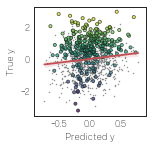

In [21]:
X_sort, y_sort, my_cv, c_sort = get_stratified_cv(X = X, y = y, c = c, n_splits = n_splits)
accuracy_nuis, y_pred = cross_val_score_nuis(X = X_sort, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
print(np.mean(accuracy_nuis))

clinical_idx_sort = clinical_idx[y_sort.index]

f, ax = plt.subplots()
f.set_figwidth(2)
f.set_figheight(2)
sns.regplot(x = y_pred, y = y_sort, color = 'r', scatter = False)
# plt.scatter(x = y_pred, y = y_sort, marker = 'o', s = 2, c = y_sort, cmap = 'viridis', alpha=0.75, linewidth = 1)
plt.scatter(x = y_pred[~clinical_idx_sort], y = y_sort[~clinical_idx_sort], marker = 'o', s = 1, c = 'gray', alpha=0.75, linewidth = .5)
plt.scatter(x = y_pred[clinical_idx_sort], y = y_sort[clinical_idx_sort],
            marker = 'o', s = 10, c = y_sort[clinical_idx_sort], cmap = 'viridis', edgecolors = 'k',
            alpha=0.75, linewidth = .75)
# plt.scatter(x = y_pred, y = y_sort, marker = 'o', s = 10, alpha=0.75, linewidth = 1)
ax.set_xlabel('Predicted y')
ax.set_ylabel('True y')
# ax.set_ylim([-3,3])
ax.set_xlim([-.9,.9])
ax.tick_params(pad = -.5)
print(sp.stats.pearsonr(y_pred,y_sort))

f.savefig(outfile_prefix+'psy_pos_'+score+'.svg', dpi = 300, bbox_inches = 'tight')

In [22]:
# X_s = X.loc[clinical_idx,:]; y_s = y.loc[clinical_idx]; c_s = c.loc[clinical_idx,:]
# X_sort, y_sort, my_cv, c_sort = get_stratified_cv(X = X_s, y = y_s, c = c_s, n_splits = n_splits)
# accuracy_clinical, y_pred = cross_val_score_nuis(X = X_sort, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
# print(np.mean(accuracy_clinical))

# f, ax = plt.subplots()
# f.set_figwidth(2)
# f.set_figheight(2)
# sns.regplot(x = y_pred, y = y_sort, color = 'r', scatter = False)
# plt.scatter(x = y_pred, y = y_sort, marker = 'o', s = 10, c = y_sort, cmap = 'viridis', alpha=0.75, linewidth = 1, edgecolors = 'k')
# ax.set_xlabel('Predicted y')
# ax.set_ylabel('True y')
# # ax.set_ylim([-3,3])
# # ax.set_xlim([-.9,.9])
# ax.tick_params(pad = -.5)
# print(sp.stats.pearsonr(y_pred,y_sort))

# f.savefig(outfile_prefix+'psy_pos_clinical_'+score+'.svg', dpi = 300, bbox_inches = 'tight')

In [23]:
# X_s, y_s, c_s = resample(X, y, c, n_samples = n, replace = False, random_state = 0)
# X_sort, y_sort, my_cv, c_sort = get_stratified_cv(X = X_s, y = y_s, c = c_s, n_splits = n_splits)
# accuracy_nuis, y_pred = cross_val_score_nuis(X = X_sort, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
# print(np.mean(accuracy_nuis))

# f, ax = plt.subplots()
# f.set_figwidth(2)
# f.set_figheight(2)
# sns.regplot(x = y_pred, y = y_sort, color = 'r', scatter = False)
# plt.scatter(x = y_pred, y = y_sort, marker = 'o', s = 10, c = y_sort, cmap = 'viridis', alpha=0.75, linewidth = 1, edgecolors = 'k')
# ax.set_xlabel('Predicted y')
# ax.set_ylabel('True y')
# # ax.set_ylim([-3,3])
# # ax.set_xlim([-.9,.9])
# ax.tick_params(pad = -.5)
# print(sp.stats.pearsonr(y_pred,y_sort))

In [24]:
# num_samples = 100

# accuracy_mean = np.zeros(num_samples)
# accuracy_std = np.zeros(num_samples)

# for i in np.arange(0,num_samples):
#     X_s, y_s, c_s = resample(X, y, c, n_samples = n, replace = False, random_state = i)
#     X_sort, y_sort, my_cv, c_sort = get_stratified_cv(X = X_s, y = y_s, c = c_s, n_splits = n_splits)
#     accuracy_nuis, y_pred = cross_val_score_nuis(X = X_sort, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)

#     accuracy_mean[i] = accuracy_nuis.mean()
#     accuracy_std[i] = accuracy_nuis.std()

In [25]:
# f, ax = plt.subplots()
# f.set_figwidth(2)
# f.set_figheight(2)
# sns.distplot(accuracy_mean, ax=ax)
# ax.axvline(accuracy_mean.mean(), color='b')
# ax.axvline(accuracy_clinical.mean(), color='r')

In [26]:
# accuracy_mean.mean()

In [27]:
# accuracy_mean.std()

In [28]:
# accuracy_mean.max()

### vs Strength

In [29]:
indir = predictiondir + 'predict_symptoms_rcv_nuis'
accuracy_mean_nuis = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_mean.txt'))
if score == 'rmse' or score == 'mae': accuracy_mean_nuis = np.abs(accuracy_mean_nuis)

indir = predictiondir + 'predict_symptoms_scv_nuis'
accuracy_mean = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_mean_nuis.txt'))
permuted_acc = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'permuted_acc_nuis.txt'))
print(accuracy_mean_nuis.mean(),np.sum(permuted_acc >= accuracy_mean) / len(permuted_acc))

0.9997089402305751 0.00299


In [30]:
indir = predictiondir + 'predict_symptoms_rcv_nuis'
accuracy_mean_nuis_str = np.loadtxt(os.path.join(indir, alg + '_' + score + '_str_' + pheno, 'accuracy_mean.txt'))
if score == 'rmse' or score == 'mae': accuracy_mean_nuis_str = np.abs(accuracy_mean_nuis_str)

indir = predictiondir + 'predict_symptoms_scv_nuis'
accuracy_mean_str = np.loadtxt(os.path.join(indir, alg + '_' + score + '_str_' + pheno, 'accuracy_mean_nuis.txt'))
permuted_acc = np.loadtxt(os.path.join(indir, alg + '_' + score + '_str_' + pheno, 'permuted_acc_nuis.txt'))
print(accuracy_mean_nuis_str.mean(),np.sum(permuted_acc >= accuracy_mean_str) / len(permuted_acc))

1.0228437862994906 0.77193


In [31]:
sns.set(style='white', context = 'paper', font_scale = 1)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Public Sans']})

0.0
0.00299
0.77193


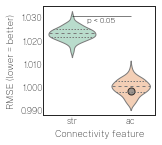

In [32]:
df_ac = pd.DataFrame(data = accuracy_mean_nuis, columns=['data']); df_ac['metric'] = 'ac'
df_str = pd.DataFrame(data = accuracy_mean_nuis_str, columns=['data']); df_str['metric'] = 'str'
p_val = get_exact_p(df_str['data'], df_ac['data'], tailed=1)
print(p_val)

data = pd.concat((df_str,df_ac), axis=0)

f, ax = plt.subplots()
f.set_figwidth(2)
f.set_figheight(2)
sns.violinplot(x = 'metric', y = 'data', data = data, inner = 'quartile', split = False, palette = 'Pastel2', linewidth = 1)
ax.tick_params(pad = -4)
ax.set_xlabel('Connectivity feature')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

if score == 'rmse':
    ax.set_ylabel('RMSE (lower = better)')
#     ax.set_ylim([ax.get_ylim()[0],
# #                  ax.get_ylim()[1]+ax.get_ylim()[1]*.01])
#                  ax.get_ylim()[1]+ax.get_ylim()[1]*.005])
elif score == 'corr':
    ax.set_ylabel('Correlation (higher = better)')
#     ax.set_ylim([ax.get_ylim()[0],
#                  ax.get_ylim()[1]+ax.get_ylim()[1]*.3])

y_pos = data['data'].max()
ax.hlines(y = y_pos, xmin = 0, xmax = 1, color = 'black', linewidth = 0.5)
if p_val < 0.05:
    ax.text(x = 0.5, y = y_pos, s = 'p < 0.05', horizontalalignment='center', verticalalignment='top', color = 'black', fontsize = 8)
else:
    ax.text(x = 0.5, y = y_pos, s = 'p = '+str(p_val), horizontalalignment='center', verticalalignment='top', color = 'black', fontsize = 8)

indir = predictiondir + 'predict_symptoms_scv_nuis'
accuracy_mean = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_mean_nuis.txt'))
permuted_acc = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'permuted_acc_nuis.txt'))
p_val_null = np.sum(permuted_acc >= accuracy_mean) / len(permuted_acc)
print(p_val_null)
if p_val_null < 0.05: ax.scatter(x = 1, y = np.abs(accuracy_mean), marker = 'o', s = 50, edgecolors = 'black', facecolors = 'gray', alpha = 0.75, linewidth = 1)       
    
accuracy_mean = np.loadtxt(os.path.join(indir, alg + '_' + score + '_str_' + pheno, 'accuracy_mean_nuis.txt'))
permuted_acc = np.loadtxt(os.path.join(indir, alg + '_' + score + '_str_' + pheno, 'permuted_acc_nuis.txt'))
p_val_null = np.sum(permuted_acc >= accuracy_mean) / len(permuted_acc)
print(p_val_null)
if p_val_null < 0.05: ax.scatter(x = 0, y = np.abs(accuracy_mean), marker = 'o', s = 20, edgecolors = 'black', facecolors = 'gray', alpha = 0.75, linewidth = 1)       
    
f.savefig(outfile_prefix+'psy_pos_'+metric+'_'+score+'.svg', dpi = 300, bbox_inches = 'tight')

### Yeo systems

In [33]:
indir = predictiondir + 'predict_symptoms_rcv_nuis'
accuracy_mean_nuis_yeo = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_mean_yeo.txt'))
if score == 'rmse' or score == 'mae': accuracy_mean_nuis_yeo = np.abs(accuracy_mean_nuis_yeo)

In [34]:
num_systems = accuracy_mean_nuis_yeo.shape[1]
unique_systems = np.arange(0,num_systems)

In [35]:
indices = np.triu_indices(num_systems,1)
indices

(array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5]),
 array([1, 2, 3, 4, 5, 6, 2, 3, 4, 5, 6, 3, 4, 5, 6, 4, 5, 6, 5, 6, 6]))

In [36]:
stats_yeo_pairs = np.zeros(len(indices[0]))

for i in np.arange(len(indices[0])):
    stats_yeo_pairs[i] = get_exact_p(accuracy_mean_nuis_yeo[:,indices[0][i]], accuracy_mean_nuis_yeo[:,indices[1][i]])
    
stats_yeo_pairs = get_fdr_p(stats_yeo_pairs)
stats_yeo_pairs

array([0.        , 0.        , 0.64      , 0.12923077, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07      , 0.21      , 0.51333333, 0.64      ,
       0.32117647, 0.224     , 0.07      , 0.64      , 0.07      ,
       0.32117647])

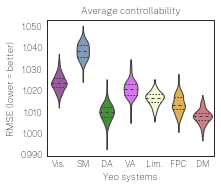

In [37]:
cmap = my_get_cmap('yeo7')

f, ax = plt.subplots()
f.set_figwidth(3)
f.set_figheight(2.5)

data = pd.DataFrame(columns=['data', 'yeo'])

for i in np.arange(accuracy_mean_nuis_yeo.shape[1]):
    tmp = pd.DataFrame(data = accuracy_mean_nuis_yeo[:,i], columns=['data'])
    tmp['yeo'] = i+1
    data = pd.concat((data,tmp), axis=0)

sns.violinplot(x = 'yeo', y = 'data', data = data, inner = 'quartile', split = False, palette = cmap, linewidth = 1, ax=ax)

ax.tick_params(pad = -.5)
if score == 'rmse': ax.set_ylabel('RMSE (lower = better)')
elif score == 'corr': ax.set_ylabel('Correlation (higher = better)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlabel('Yeo systems')
# ax.set_xticklabels(['Visual', 'Somatomotor', 'Dorsal attention', 'Ventral attention', 'Limbic', 'Frontoparietal control', 'Default mode'], rotation=90)
ax.set_xticklabels(['Vis.', 'SM', 'DA', 'VA', 'Lim.', 'FPC', 'DM'])
ax.set_title(metrics_label[m])

# for i in np.arange(len(indices[0])):
#     if stats_yeo_pairs[i] < 0.05:
#         y_pos = np.max(list(accuracy_mean_nuis_yeo[:,indices[0][i]]) + list(accuracy_mean_nuis_yeo[:,indices[1][i]]))
#         ax.hlines(y = y_pos, xmin = indices[0][i], xmax = indices[1][i], color = 'black', linewidth = 0.5)
#         ax.text(x = np.mean([indices[0][i],indices[1][i]]), y = y_pos, s =  '*', horizontalalignment='center', verticalalignment='top', color = 'black', fontsize = 8)
        
f.savefig(outfile_prefix+'psy_pos_'+metric+'_'+score+'_yeo.svg', dpi = 300, bbox_inches = 'tight')